In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import serial
import time
from serialPorts import *
import re
from scipy.optimize import curve_fit

BAUD_RATE = 115200

In [12]:
def main():
    global fig
    # First get the name of and open the serial port
    ports = serial_ports()
    print "The default options are shown in CAPS"
    print "The available ports are:"
    for (i, port) in enumerate(ports):
        print "%d: %s" % (i, port)
    iPort = int(raw_input("Enter serial port number: "))
    port = ports[iPort]

    ser = serial.Serial(port, BAUD_RATE, timeout=1) #for checked in Devices

    # the first open resets the Arduino, so immediately read the Arduino
    # Note that readlines reads until it times out
    lines = ser.readlines()
    ser.write("\n")
    lines = ser.readlines()
      
    (VData, IData) = getData(lines)
    nPoints = len(VData)
    print "Read %d data points" % (nPoints)
    if nPoints > 0:
        plotFitData(VData, IData)

    # The main loop
    done = False
    while not done:
        ans = raw_input("Gather another I-V data set (Y/n): ")
        if len(ans) > 0 and (ans[0] == 'n' or ans[0] == 'N'):
          done = True
          break
        
        if fig:
            print "Close fig"
            plt.close(fig)
            fig = None

        print "Getting I-V data"
        ser.write("\n")
        lines = ser.readlines()

        # plot and fit data
        (VData, IData) = getData(lines)
        nPoints = len(VData)
        print "Read %d data points" % (nPoints)
        plotFitData(VData, IData)

    # clean up
    ser.close()
    print "Done"
    return (VData, IData)

def getData(lines):
    # This function reads the Arduino output and finds the data points
    #
    # define patterns for string matching
    # This crazy line looks for two commas separated numbers
    dataLine = re.compile(r"(-?[0-9.]+)\s*,\s*(-?[0-9.]+)")
    
    # start empty data lists
    IData = []
    VData = []
    nPoints = 0
    
    # scan all of the lines looking for data
    for (iLine, line) in enumerate(lines):
        matchObj = dataLine.search(line)
        if matchObj:
            VData.append(float(matchObj.group(1)))
            IData.append(float(matchObj.group(2)))
            nPoints += 1
    
    # convert data to numpy arrays
    VData = np.array(VData, dtype=float)
    IData = np.array(IData, dtype=float)
    return (VData, IData)

def funcLin(x, m, b):
    return m * x + b

def quadDiode(V, V0, a):
    return np.where(V<=V0,0,a * (V - V0)**2)

fig = None
def plotFitData(VData, IData):
    global fig
    # Plot the data
    nPoints = len(VData)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(VData, IData, '.')
    ax.set_xlabel("Volts (V)")
    ax.set_ylabel("Current (A)")
    
    # Fit the data to linear (resistance)
    popt, pcov = curve_fit(funcLin, VData, IData)
    perr = np.sqrt(np.diag(pcov))
    if popt[0] != 0:
        R = 1.0 / popt[0]
    else:
        R = 1e7
    R_Err = perr[0]*R**2
    IFitLin = funcLin(VData, popt[0], popt[1])
    
    # plot linear fit
    ax.plot(VData, IFitLin, '-r')
    textLin = "R = %.2f $\pm$ %.2f Ohms" % (R, R_Err)
    ax.text(.05, .95, textLin, transform=ax.transAxes)
    ax.grid(True)
    
    # Fit the data to a quadratic turn on voltage (diode)    
    popt, pcov = curve_fit(quadDiode, VData, IData, p0=(1.2,1))
    V0Fit = popt[0]
    aFit = popt[1]
    perr_Quad = np.sqrt(np.diag(pcov))
    textQuad = "V_0 = %.3f $\pm$ %.3f" % (V0Fit, perr_Quad[0])

    IFitQuad = quadDiode(VData, V0Fit, aFit)
    ax.plot(VData, IFitQuad, '-', color="g", alpha=0.5, lw=2)
    ax.text(.05, .90, textQuad, transform=ax.transAxes)

    plt.ion()
    plt.show()
    ans = raw_input("Save figure (N/y)? ")
    if len(ans) > 0 and (ans[0] == 'y' or ans[0] == 'Y'):
        title = raw_input("Enter plot title: ")
        ax.set_title(title)
        fName = raw_input("Enter file name (without the .png): ")
        plt.savefig(fName+".png", dpi=300)
    plt.close('all')
    fig = None

The default options are shown in CAPS
The available ports are:
0: /dev/tty.Bluetooth-Incoming-Port
1: /dev/tty.usbmodem1421
Enter serial port number: 1
Read 0 data points
Gather another I-V data set (Y/n): 
Getting I-V data
Read 256 data points


/Users/michaelhuster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:103: RuntimeWarning: divide by zero encountered in double_scalars
/Users/michaelhuster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:104: RuntimeWarning: invalid value encountered in double_scalars


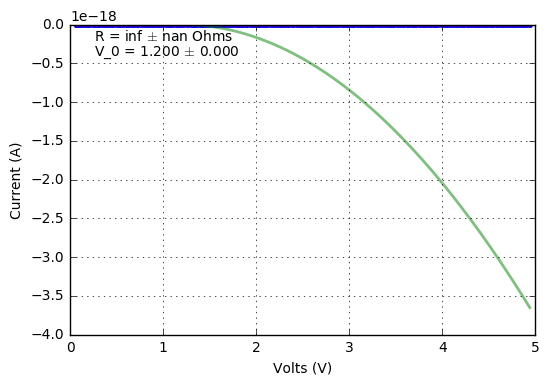

Save figure (N/y)? n
Gather another I-V data set (Y/n): n
Done


In [13]:
(VData, IData) = main()

In [ ]:
print min(VData), max(VData)
print min(IData), max(IData)

In [ ]:
VData = np.linspace(0,5)
IData = quadDiode(VData, V0=1.6,a=0.01) + np.random.normal(loc=0.0, scale=0.001, size=VData.size)
txtQuad = "V0 = %.3f $\pm$ %.3f" % (V0Fit, perr_Quad[0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(VData, IData, '.')
ax.text(.05, .95, txtQuad, transform=ax.transAxes)
ax.text(.05, .90, txtQuad, transform=ax.transAxes)

In [ ]:
a = np.arange(0,10.)
b = np.where(a<=5,0,(a-5)**2)
print a
print b